<a href="https://colab.research.google.com/github/Ciss48/Crazy_Coffee_Game_Analysis/blob/main/Crazy_Coffee_User_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [3]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

project_id = 'crazy-coffee-jam'

In [4]:
from google.colab import auth
auth.authenticate_user()
# Construct a BigQuery client object.
from google.cloud import bigquery
client = bigquery.Client(project=project_id)

# Segment by attemp

In [5]:
query = """
with c as
(
  select distinct user_pseudo_id from `crazy-coffee-jam.flatten_table.win_level`
  where level >= 15
  AND user_pseudo_id IN (
    SELECT DISTINCT user_pseudo_id
    FROM `crazy-coffee-jam.flatten_table.first_open`
    WHERE event_date >= '2025-05-01'
  )
)
, b as (
select user_pseudo_id, count(*) as time_start
from `crazy-coffee-jam.flatten_table.start_level`
where user_pseudo_id in (select user_pseudo_id from c)
and level <= 15
group by  user_pseudo_id
having time_start >= 15
)
SELECT
  user_pseudo_id,
  COUNT(*) AS start_time
FROM `crazy-coffee-jam.flatten_table.start_level`
WHERE level <= 15
  AND user_pseudo_id IN (SELECT DISTINCT user_pseudo_id FROM b )
GROUP BY user_pseudo_id
"""
user_segment = client.query(query).to_dataframe()
user_segment

,user_pseudo_id,start_time
0,213e2baa941de644425c3a4a65dbfd91,15
1,7d8de89f2c7dd30748b574ad8ac4210c,16
2,5204c3fb476f6bf9dfa63a20989af4a6,15
3,95ceec3e25e340f59681b54abe4d08d8,16
4,cba676d03f7f30a6e95e02bc01b45c60,15
...,...,...
5678,bbb25bec67e82eff01575ff24c116aaf,15
5679,bda461402ae7e1a29158f890d33f3d4a,16
5680,c4e124b3f05278163ed3019a74488545,15
5681,dfe7dc965e81b51c3121ec652163349a,16


In [6]:
# prompt: Sử dụng dataframe user_segment:  thêm cột cluster: good cho user có start_time = 15, not_good cho nhóm còn lại. Sau đó đếm số lượng mỗi nhóm

# Thêm cột 'cluster' dựa trên điều kiện start_time
user_segment['cluster'] = user_segment['start_time'].apply(lambda x: 'good' if x == 15 else 'not_good')

# Đếm số lượng mỗi nhóm
cluster_counts = user_segment['cluster'].value_counts()

# In kết quả đếm số lượng
cluster_counts

,count
cluster,
good,3553
not_good,2130


## Đánh giá 2 nhóm

In [7]:
# prompt: Tạo 2 list cho 2 nhóm user vừa cluster ra

good_users = user_segment[user_segment['cluster'] == 'good']['user_pseudo_id'].tolist()
not_good_users = user_segment[user_segment['cluster'] == 'not_good']['user_pseudo_id'].tolist()

good_user_list_str = "', '".join(good_users)
not_good_user_list_str = "', '".join(not_good_users)

In [ ]:
query1 = """
WITH start_events AS (
  SELECT
    level,
    COUNT(user_pseudo_id) as event_start,
    COUNT( DISTINCT user_pseudo_id) as user_start
  FROM `crazy-coffee-jam.flatten_table.start_level`
  WHERE event_date >= '2025-05-01'
  AND user_pseudo_id IN ('{good_user_list_str}')
  GROUP BY  level
),
win_events AS (
  SELECT
    level,
    COUNT(user_pseudo_id) as event_win,
    COUNT( DISTINCT user_pseudo_id) as user_win
  FROM `crazy-coffee-jam.flatten_table.win_level`
  WHERE event_date >= '2025-05-01'
  AND user_pseudo_id IN ('{good_user_list_str}')
  GROUP BY  level
),
lose_events AS (
  SELECT
    level,
    COUNT(user_pseudo_id) as event_lose,
    COUNT( DISTINCT user_pseudo_id) as user_lose
  FROM `crazy-coffee-jam.flatten_table.lose_level`
  WHERE event_date >= '2025-05-01'
  AND user_pseudo_id IN ('{good_user_list_str}')
  GROUP BY  level
),
revive_events as (
  SELECT
    level,
    COUNT(user_pseudo_id) as event_revive,
    COUNT( DISTINCT user_pseudo_id) as user_revive
  FROM `crazy-coffee-jam.flatten_table.revive_level`
  WHERE event_date >= '2025-05-01'
  AND user_pseudo_id IN ('{good_user_list_str}')
  GROUP BY  level
),
booster_use as (
  SELECT
    level,
    COUNT(user_pseudo_id) as num_booster_use
  FROM `crazy-coffee-jam.flatten_table.booster_use`
  where event_date >= '2025-05-01'
  AND user_pseudo_id IN ('{good_user_list_str}')
  GROUP BY  level
),
ad_reward as (
  SELECT
    level,
    COUNT(user_pseudo_id) as num_ad_reward
  FROM `crazy-coffee-jam.flatten_table.af_rewarded`
  where event_date >= '2025-05-01'
  AND user_pseudo_id IN ('{good_user_list_str}')
  GROUP BY  level
),
play_level_time as (
  SELECT
    level,
    sum(count_sec) as play_level_time_sec
  FROM `crazy-coffee-jam.flatten_table.all_play_level_time`
  where event_date >= '2025-05-01'
  AND user_pseudo_id IN ('{good_user_list_str}')
  GROUP BY  level
),
win_level_time as (
  SELECT
    level,
    sum(count_sec) as play_level_time_sec
  FROM `crazy-coffee-jam.flatten_table.win_level_time`
  where event_date >= '2025-05-01'
  AND user_pseudo_id IN ('{good_user_list_str}')
  GROUP BY  level
)
SELECT
  s.level,
  s.event_start as event_start_good_user,
  w.event_win as event_win_good_user,
  l.event_lose as event_lose_good_user,
  r.event_revive as event_revive_good_user,
  s.user_start as user_start_good_user,
  b.num_booster_use as num_booster_use_good_user,
  a.num_ad_reward as num_ad_reward_good_user,
  p.play_level_time_sec as play_level_time_sec_good_user,
  wl.play_level_time_sec as win_level_time_sec_good_user
FROM start_events s
LEFT JOIN win_events w
  ON s.level = w.level
LEFT JOIN lose_events l
  ON s.level = l.level
LEFT JOIN revive_events r
  ON s.level = r.level
LEFT JOIN booster_use b
  ON s.level = b.level
LEFT JOIN ad_reward a
  ON s.level = a.level
LEFT JOIN play_level_time p
  ON s.level = p.level
LEFT JOIN win_level_time wl
  ON s.level = wl.level

"""

# Format the query with the actual user list string
query1 = query1.format(good_user_list_str=good_user_list_str)

# Execute query and store results
winrate_good_user = client.query(query1).to_dataframe()

query1 = """
WITH start_events AS (
  SELECT
    level,
    COUNT(user_pseudo_id) as event_start,
    COUNT( DISTINCT user_pseudo_id) as user_start
  FROM `crazy-coffee-jam.flatten_table.start_level`
  WHERE event_date >= '2025-05-01'
  AND user_pseudo_id IN ('{not_good_user_list_str}')
  GROUP BY  level
),
win_events AS (
  SELECT
    level,
    COUNT(user_pseudo_id) as event_win,
    COUNT( DISTINCT user_pseudo_id) as user_win
  FROM `crazy-coffee-jam.flatten_table.win_level`
  WHERE event_date >= '2025-05-01'
  AND user_pseudo_id IN ('{not_good_user_list_str}')
  GROUP BY  level
),
lose_events AS (
  SELECT
    level,
    COUNT(user_pseudo_id) as event_lose,
    COUNT( DISTINCT user_pseudo_id) as user_lose
  FROM `crazy-coffee-jam.flatten_table.lose_level`
  WHERE event_date >= '2025-05-01'
  AND user_pseudo_id IN ('{not_good_user_list_str}')
  GROUP BY  level
),
revive_events as (
  SELECT
    level,
    COUNT(user_pseudo_id) as event_revive,
    COUNT( DISTINCT user_pseudo_id) as user_revive
  FROM `crazy-coffee-jam.flatten_table.revive_level`
  WHERE event_date >= '2025-05-01'
  AND user_pseudo_id IN ('{not_good_user_list_str}')
  GROUP BY  level
),
booster_use as (
  SELECT
    level,
    COUNT(user_pseudo_id) as num_booster_use
  FROM `crazy-coffee-jam.flatten_table.booster_use`
  where event_date >= '2025-05-01'
  AND user_pseudo_id IN ('{not_good_user_list_str}')
  GROUP BY  level
),
ad_reward as (
  SELECT
    level,
    COUNT(user_pseudo_id) as num_ad_reward
  FROM `crazy-coffee-jam.flatten_table.af_rewarded`
  where event_date >= '2025-05-01'
  AND user_pseudo_id IN ('{not_good_user_list_str}')
  GROUP BY  level
),
play_level_time as (
  SELECT
    level,
    sum(count_sec) as play_level_time_sec
  FROM `crazy-coffee-jam.flatten_table.all_play_level_time`
  where event_date >= '2025-05-01'
  AND user_pseudo_id IN ('{not_good_user_list_str}')
  GROUP BY  level
),
win_level_time as (
  SELECT
    level,
    sum(count_sec) as play_level_time_sec
  FROM `crazy-coffee-jam.flatten_table.win_level_time`
  where event_date >= '2025-05-01'
  AND user_pseudo_id IN ('{not_good_user_list_str}')
  GROUP BY  level
)
SELECT
  s.level,
  s.event_start as event_start_not_good_user,
  w.event_win as event_win_not_good_user,
  l.event_lose as event_lose_not_good_user,
  r.event_revive as event_revive_not_good_user,
  s.user_start as user_start_not_good_user,
  b.num_booster_use as num_booster_use_not_good_user,
  a.num_ad_reward as num_ad_reward_not_good_user,
  p.play_level_time_sec as play_level_time_sec_not_good_user,
  wl.play_level_time_sec as win_level_time_sec_not_good_user
FROM start_events s
LEFT JOIN win_events w
  ON s.level = w.level
LEFT JOIN lose_events l
  ON s.level = l.level
LEFT JOIN revive_events r
  ON s.level = r.level
LEFT JOIN booster_use b
  ON s.level = b.level
LEFT JOIN ad_reward a
  ON s.level = a.level
LEFT JOIN play_level_time p
  ON s.level = p.level
LEFT JOIN win_level_time wl
  ON s.level = wl.level
"""

# Format the query with the actual user list string
query1 = query1.format(not_good_user_list_str=not_good_user_list_str)

# Execute query and store results
winrate_not_good_user = client.query(query1).to_dataframe()

In [ ]:
# Merge the two dataframes on level and fill null values with 0
winrate_combined = pd.merge(winrate_good_user, winrate_not_good_user,
                          on='level',
                          how='outer').fillna(0)

# Calculate winrates
winrate_combined['winrate_good_user'] = winrate_combined['event_win_good_user'] / (
    winrate_combined['event_win_good_user'] +
    winrate_combined['event_lose_good_user'] +
    winrate_combined['event_revive_good_user']
)

winrate_combined['winrate_not_good_user'] = winrate_combined['event_win_not_good_user'] / (
    winrate_combined['event_win_not_good_user'] +
    winrate_combined['event_lose_not_good_user'] +
    winrate_combined['event_revive_not_good_user']
)

# Get level 1 user starts
user_start_good_lv1 = winrate_combined.loc[winrate_combined['level'] == 1, 'user_start_good_user'].iloc[0]
user_start_not_good_lv1 = winrate_combined.loc[winrate_combined['level'] == 1, 'user_start_not_good_user'].iloc[0]

# Add level 1 user starts as columns
winrate_combined['user_start_good_user_lv1'] = user_start_good_lv1
winrate_combined['user_start_not_good_user_lv1'] = user_start_not_good_lv1

# Calculate drop rates from level 1
winrate_combined['drop_by_lv1_good_user'] = winrate_combined['user_start_good_user'] / winrate_combined['user_start_good_user_lv1']
winrate_combined['drop_by_lv1_not_good_user'] = winrate_combined['user_start_not_good_user'] / winrate_combined['user_start_not_good_user_lv1']


winrate_combined['num_booster_use_per_start_good_user'] = winrate_combined['num_booster_use_good_user'] / winrate_combined['user_start_good_user']
winrate_combined['num_booster_use_per_start_not_good_user'] = winrate_combined['num_booster_use_not_good_user'] / winrate_combined['user_start_not_good_user']

winrate_combined['num_ad_reward_per_start_good_user'] = winrate_combined['num_ad_reward_good_user'] / winrate_combined['user_start_good_user']
winrate_combined['num_ad_reward_per_start_not_good_user'] = winrate_combined['num_ad_reward_not_good_user'] / winrate_combined['user_start_not_good_user']

winrate_combined['play_level_time_sec_per_start_good_user'] = winrate_combined['play_level_time_sec_good_user'] / winrate_combined['user_start_good_user']
winrate_combined['play_level_time_sec_per_start_not_good_user'] = winrate_combined['play_level_time_sec_not_good_user'] / winrate_combined['user_start_not_good_user']

winrate_combined['win_level_time_sec_per_start_good_user'] = winrate_combined['win_level_time_sec_good_user'] / winrate_combined['user_start_good_user']
winrate_combined['win_level_time_sec_per_start_not_good_user'] = winrate_combined['win_level_time_sec_not_good_user'] / winrate_combined['user_start_not_good_user']

winrate_combined = winrate_combined[winrate_combined['level'] <= 50]


# Clip values greater than 1 to 1 for drop rate columns
winrate_combined['drop_by_lv1_good_user'] = winrate_combined['drop_by_lv1_good_user'].clip(upper=1)
winrate_combined['drop_by_lv1_not_good_user'] = winrate_combined['drop_by_lv1_not_good_user'].clip(upper=1)

# Add next level user starts
winrate_combined['user_good_start_next_level'] = winrate_combined['user_start_good_user'].shift(-1)
winrate_combined['user_not_good_start_next_level'] = winrate_combined['user_start_not_good_user'].shift(-1)

# Calculate drop by level
winrate_combined['drop_by_level_good_user'] = 1 - (winrate_combined['user_good_start_next_level'] / winrate_combined['user_start_good_user'])
winrate_combined['drop_by_level_not_good_user'] = 1 - (winrate_combined['user_not_good_start_next_level'] / winrate_combined['user_start_not_good_user'])

# Set drop by level values to 0 for levels 1-15
winrate_combined.loc[(winrate_combined['level'] >= 1) & (winrate_combined['level'] <= 15), 'drop_by_level_good_user'] = 0
winrate_combined.loc[(winrate_combined['level'] >= 1) & (winrate_combined['level'] <= 15), 'drop_by_level_not_good_user'] = 0

winrate_combined

,level,event_start_good_user,event_win_good_user,event_lose_good_user,event_revive_good_user,user_start_good_user,num_booster_use_good_user,num_ad_reward_good_user,play_level_time_sec_good_user,win_level_time_sec_good_user,...,num_ad_reward_per_start_good_user,num_ad_reward_per_start_not_good_user,play_level_time_sec_per_start_good_user,play_level_time_sec_per_start_not_good_user,win_level_time_sec_per_start_good_user,win_level_time_sec_per_start_not_good_user,user_good_start_next_level,user_not_good_start_next_level,drop_by_level_good_user,drop_by_level_not_good_user
0,1,3551,3552,0,0,3549,0,114,522666,673560,...,0.032122,0.031339,147.271344,168.211301,189.788673,225.910731,3551,2104,0.0,0.0
1,2,3552,3552,0,0,3551,0,110,1054085,1358870,...,0.030977,0.023289,296.841735,339.856939,382.672487,456.75808,3551,2104,0.0,0.0
2,3,3552,3551,0,0,3551,0,100,1043205,1345318,...,0.028161,0.020437,293.777809,335.671578,378.856097,451.262833,3551,2104,0.0,0.0
3,4,3553,3550,0,0,3551,0,92,997287,1285789,...,0.025908,0.018536,280.846804,318.230989,362.092087,427.156844,3551,2106,0.0,0.0
4,5,3551,3538,0,1,3551,0,87,971117,1251693,...,0.0245,0.016619,273.477049,309.201804,352.490284,415.564577,3549,2097,0.0,0.0
5,6,3550,3548,0,4,3549,0,98,513816,662455,...,0.027613,0.021936,144.777684,158.465427,186.659622,213.208393,3548,2093,0.0,0.0
6,7,3549,3550,0,0,3548,0,98,613521,792845,...,0.027621,0.0172,172.920237,197.435738,223.462514,267.064978,3550,2112,0.0,0.0
7,8,3558,3549,1,52,3550,3567,155,398167,511098,...,0.043662,0.069129,112.159718,117.377841,143.971268,151.257102,3548,2112,0.0,0.0
8,9,3549,3549,0,3,3548,25,101,465138,601912,...,0.028467,0.029356,131.098647,139.116477,169.648253,188.537405,3549,2114,0.0,0.0
9,10,3552,3551,1,0,3549,8,96,561328,727413,...,0.02705,0.020814,158.165117,178.025544,204.962806,243.804163,3549,2116,0.0,0.0


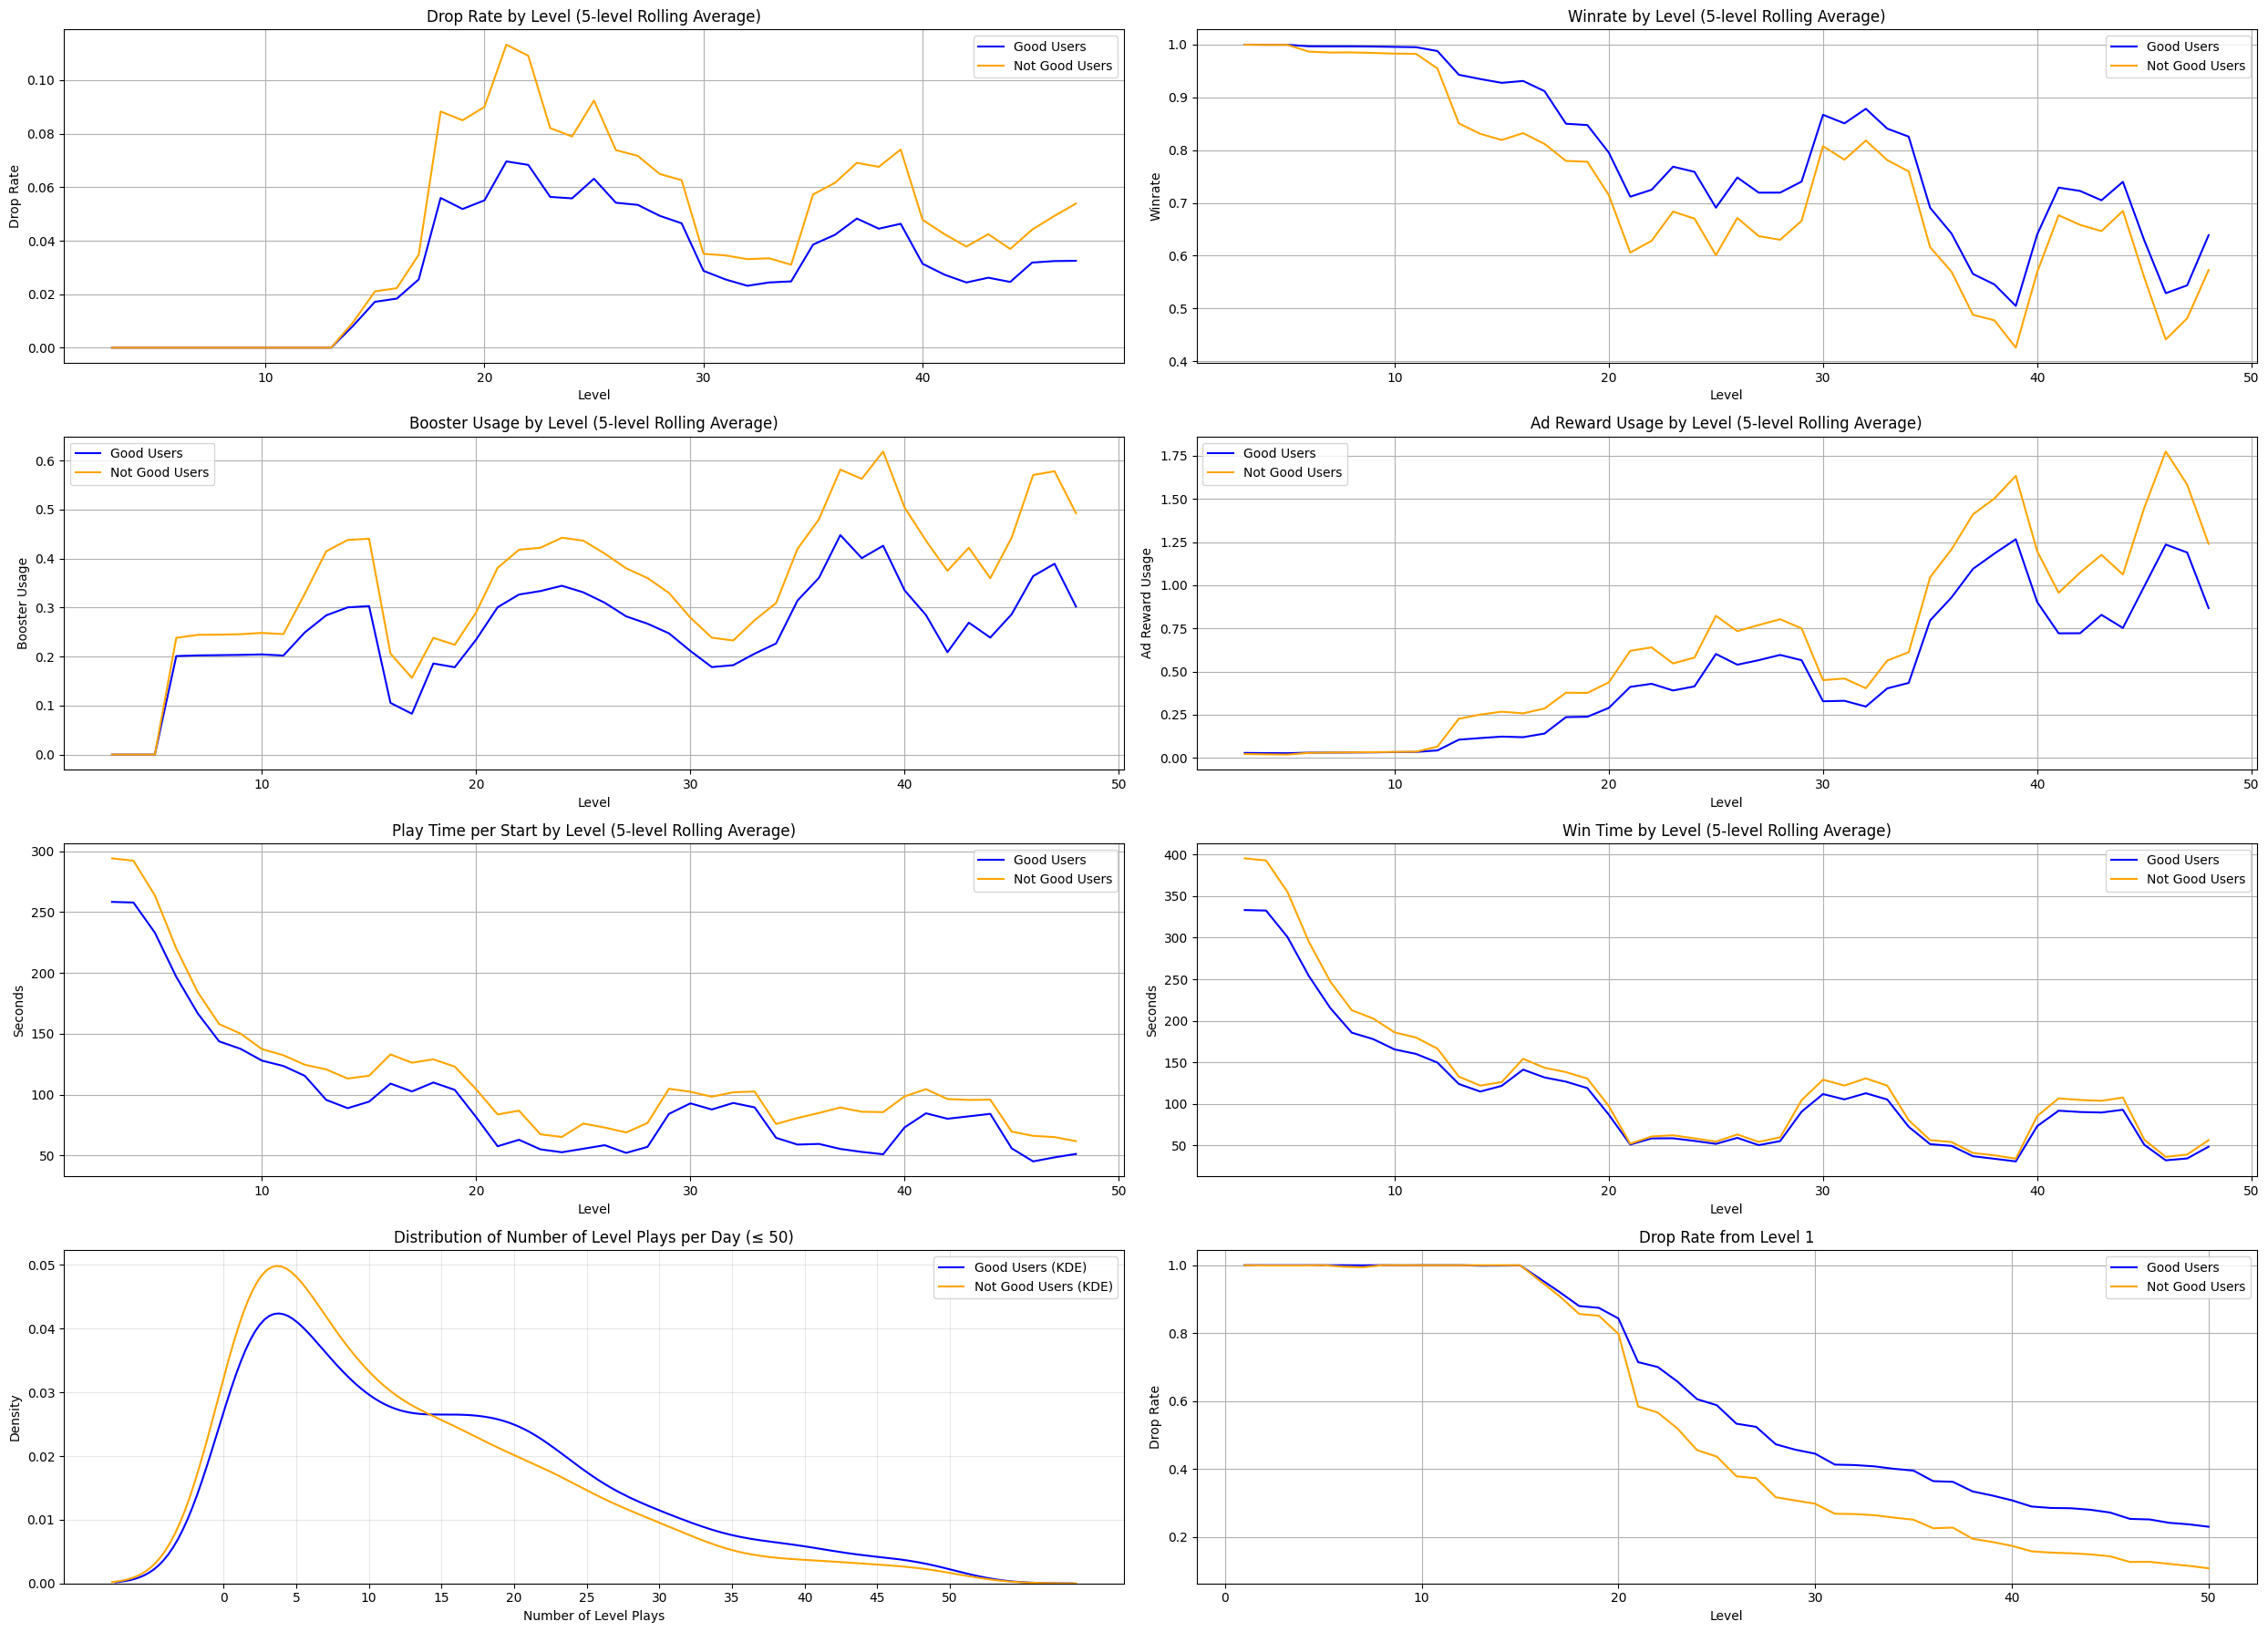

In [ ]:
# Filter data for level <= 50
filtered_data = winrate_combined[winrate_combined['level'] <= 50]

# Create figure and subplots
fig, axes = plt.subplots(4, 2, figsize=(25, 18))

# Calculate 5-level rolling averages
drop_good_rolling = filtered_data['drop_by_level_good_user'].rolling(window=5, center=True).mean()
drop_not_good_rolling = filtered_data['drop_by_level_not_good_user'].rolling(window=5, center=True).mean()
winrate_good_rolling = filtered_data['winrate_good_user'].rolling(window=5, center=True).mean()
winrate_not_good_rolling = filtered_data['winrate_not_good_user'].rolling(window=5, center=True).mean()
booster_good_rolling = filtered_data['num_booster_use_per_start_good_user'].rolling(window=5, center=True).mean()
booster_not_good_rolling = filtered_data['num_booster_use_per_start_not_good_user'].rolling(window=5, center=True).mean()
ad_good_rolling = filtered_data['num_ad_reward_per_start_good_user'].rolling(window=5, center=True).mean()
ad_not_good_rolling = filtered_data['num_ad_reward_per_start_not_good_user'].rolling(window=5, center=True).mean()
play_good_rolling = filtered_data['play_level_time_sec_per_start_good_user'].rolling(window=5, center=True).mean()
play_not_good_rolling = filtered_data['play_level_time_sec_per_start_not_good_user'].rolling(window=5, center=True).mean()
win_good_rolling = filtered_data['win_level_time_sec_per_start_good_user'].rolling(window=5, center=True).mean()
win_not_good_rolling = filtered_data['win_level_time_sec_per_start_not_good_user'].rolling(window=5, center=True).mean()

# Plot drop rates by level
axes[0,0].plot(filtered_data['level'], drop_good_rolling, color='blue', label='Good Users')
axes[0,0].plot(filtered_data['level'], drop_not_good_rolling, color='orange', label='Not Good Users')
axes[0,0].set_title('Drop Rate by Level (5-level Rolling Average)')
axes[0,0].set_xlabel('Level')
axes[0,0].set_ylabel('Drop Rate')
axes[0,0].legend()
axes[0,0].grid(True)

# Plot winrates
axes[0,1].plot(filtered_data['level'], winrate_good_rolling, color='blue', label='Good Users')
axes[0,1].plot(filtered_data['level'], winrate_not_good_rolling, color='orange', label='Not Good Users')
axes[0,1].set_title('Winrate by Level (5-level Rolling Average)')
axes[0,1].set_xlabel('Level')
axes[0,1].set_ylabel('Winrate')
axes[0,1].legend()
axes[0,1].grid(True)

# Plot booster usage
axes[1,0].plot(filtered_data['level'], booster_good_rolling, color='blue', label='Good Users')
axes[1,0].plot(filtered_data['level'], booster_not_good_rolling, color='orange', label='Not Good Users')
axes[1,0].set_title('Booster Usage by Level (5-level Rolling Average)')
axes[1,0].set_xlabel('Level')
axes[1,0].set_ylabel('Booster Usage')
axes[1,0].legend()
axes[1,0].grid(True)

# Plot ad reward usage
axes[1,1].plot(filtered_data['level'], ad_good_rolling, color='blue', label='Good Users')
axes[1,1].plot(filtered_data['level'], ad_not_good_rolling, color='orange', label='Not Good Users')
axes[1,1].set_title('Ad Reward Usage by Level (5-level Rolling Average)')
axes[1,1].set_xlabel('Level')
axes[1,1].set_ylabel('Ad Reward Usage')
axes[1,1].legend()
axes[1,1].grid(True)

# Plot play time per start
axes[2,0].plot(filtered_data['level'], play_good_rolling, color='blue', label='Good Users')
axes[2,0].plot(filtered_data['level'], play_not_good_rolling, color='orange', label='Not Good Users')
axes[2,0].set_title('Play Time per Start by Level (5-level Rolling Average)')
axes[2,0].set_xlabel('Level')
axes[2,0].set_ylabel('Seconds')
axes[2,0].legend()
axes[2,0].grid(True)

# Plot win time
axes[2,1].plot(filtered_data['level'], win_good_rolling, color='blue', label='Good Users')
axes[2,1].plot(filtered_data['level'], win_not_good_rolling, color='orange', label='Not Good Users')
axes[2,1].set_title('Win Time by Level (5-level Rolling Average)')
axes[2,1].set_xlabel('Level')
axes[2,1].set_ylabel('Seconds')
axes[2,1].legend()
axes[2,1].grid(True)



## 2 last plot
query1 = f"""
select *
from `crazy-coffee-jam.dashboard_table.avg_level_play`
where event_date >= '2025-05-01'
and user_pseudo_id in ('{good_user_list_str}')
"""
level_play_per_day_good_user = client.query(query1).to_dataframe()
filtered_data_good = level_play_per_day_good_user[level_play_per_day_good_user['num_level_play'] <= 50]

query2 = f"""
select *
from `crazy-coffee-jam.dashboard_table.avg_level_play`
where event_date >= '2025-05-01'
and user_pseudo_id in ('{not_good_user_list_str}')
"""
level_play_per_day_not_good_user = client.query(query2).to_dataframe()
filtered_data_not_good = level_play_per_day_not_good_user[level_play_per_day_not_good_user['num_level_play'] <= 50]

# Plot KDE of number of level plays
sns.kdeplot(data=filtered_data_good['num_level_play'], bw_adjust=1.5, color='blue', label='Good Users (KDE)', ax=axes[3,0])
sns.kdeplot(data=filtered_data_not_good['num_level_play'], bw_adjust=1.5, color='orange', label='Not Good Users (KDE)', ax=axes[3,0])
axes[3,0].set_xlabel('Number of Level Plays')
axes[3,0].set_ylabel('Density')
axes[3,0].set_title('Distribution of Number of Level Plays per Day (≤ 50)')
axes[3,0].set_xticks(range(0, 51, 5))
axes[3,0].grid(True, alpha=0.3)
axes[3,0].legend()

# Plot drop rates from level 1
axes[3,1].plot(filtered_data['level'], filtered_data['drop_by_lv1_good_user'], color='blue', label='Good Users')
axes[3,1].plot(filtered_data['level'], filtered_data['drop_by_lv1_not_good_user'], color='orange', label='Not Good Users')
axes[3,1].set_title('Drop Rate from Level 1')
axes[3,1].set_xlabel('Level')
axes[3,1].set_ylabel('Drop Rate')
axes[3,1].legend()
axes[3,1].grid(True)

plt.tight_layout()
plt.show()

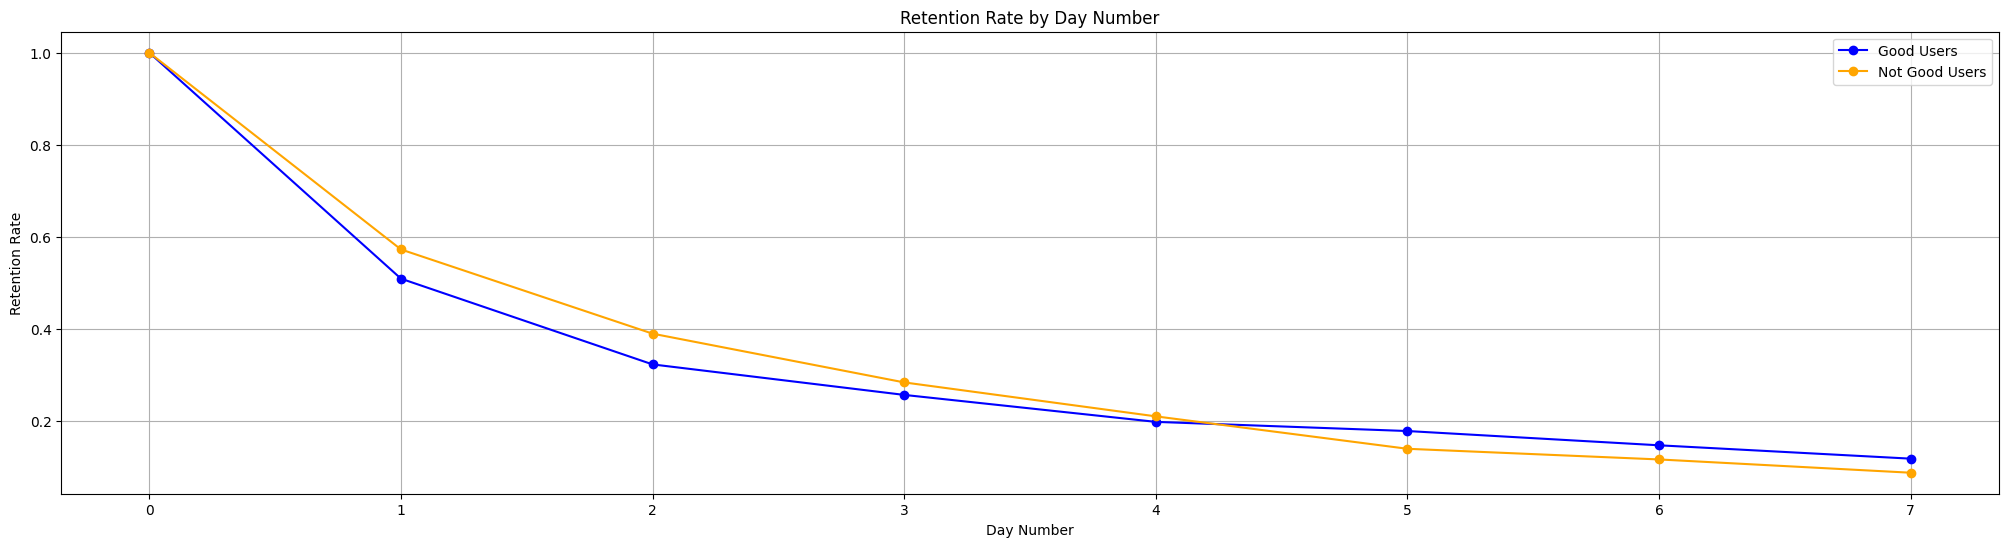

In [ ]:
query = f"""
with  first_open_dates as (
  select
    user_pseudo_id,
    min(event_date) as first_open_date
  from `crazy-coffee-jam.flatten_table.first_open`
  where user_pseudo_id in ('{good_user_list_str}')
  and event_date >= '2025-05-01'
  group by user_pseudo_id
),
engagement as (
select distinct user_pseudo_id, event_date
from `crazy-coffee-jam.flatten_table.user_engagement`
where event_date >= '2025-05-01'
),
 retention_data as (
  select
    f.user_pseudo_id,
    f.first_open_date,
    e.event_date,
    date_diff(e.event_date, f.first_open_date, DAY) as day_number
  from first_open_dates f
  left join engagement e
    on f.user_pseudo_id = e.user_pseudo_id
  where date_diff(e.event_date, f.first_open_date, DAY) between 0 and 7
)
  select
    day_number,
    count(distinct user_pseudo_id) as retained_users
  from retention_data
  group by day_number order by day_number
"""
ret_adrw = client.query(query).to_dataframe()
# Calculate retention rate relative to day 0 users
day0_users = ret_adrw.loc[ret_adrw['day_number']==0, 'retained_users'].iloc[0]
ret_adrw['retention_rate'] = ret_adrw['retained_users'] / day0_users

query = f"""
with first_open_dates as (
  select
    user_pseudo_id,
    min(event_date) as first_open_date
  from `crazy-coffee-jam.flatten_table.first_open`
  where user_pseudo_id in ('{not_good_user_list_str}')
  and event_date >= '2025-05-01'
  group by user_pseudo_id
), engagement as (
select distinct user_pseudo_id, event_date
from `crazy-coffee-jam.flatten_table.user_engagement`
where event_date >= '2025-05-01'
),
retention_data as (
  select
    f.user_pseudo_id,
    f.first_open_date,
    e.event_date,
    date_diff(e.event_date, f.first_open_date, DAY) as day_number
  from first_open_dates f
  left join engagement e
    on f.user_pseudo_id = e.user_pseudo_id
  where date_diff(e.event_date, f.first_open_date, DAY) between 0 and 7
)
  select
    day_number,
    count(distinct user_pseudo_id) as retained_users
  from retention_data
  group by day_number order by day_number
"""
ret_nonadrw = client.query(query).to_dataframe()
# Calculate retention rate relative to day 0 users
day0_users = ret_nonadrw.loc[ret_nonadrw['day_number']==0, 'retained_users'].iloc[0]
ret_nonadrw['retention_rate'] = ret_nonadrw['retained_users'] / day0_users

plt.figure(figsize=(25,6))
plt.plot(ret_adrw['day_number'], ret_adrw['retention_rate'], color = 'blue', label='Good Users',  marker='o')
plt.plot(ret_nonadrw['day_number'], ret_nonadrw['retention_rate'], color = 'orange', label='Not Good Users', marker='o')
plt.xlabel('Day Number')
plt.ylabel('Retention Rate')
plt.title('Retention Rate by Day Number')
plt.grid(True)
plt.legend()
plt.show()